In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset, get_multi_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight, target = get_tubingen_pairs_dataset(
 data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/pairs/files'
)

Load cause-effect pairs: 100%|██████████| 100/100 [00:01<00:00, 68.41it/s]


In [4]:
for i in range(len(x)):
    print(i, x[i].shape)

0 (349, 1)
1 (349, 1)
2 (349, 1)
3 (349, 1)
4 (4177, 1)
5 (4177, 1)
6 (4177, 1)
7 (4177, 1)
8 (4177, 1)
9 (4177, 1)
10 (4177, 1)
11 (5000, 1)
12 (392, 1)
13 (392, 1)
14 (392, 1)
15 (392, 1)
16 (5000, 1)
17 (314, 1)
18 (194, 1)
19 (349, 1)
20 (349, 1)
21 (450, 1)
22 (452, 1)
23 (451, 1)
24 (1030, 1)
25 (1030, 1)
26 (1030, 1)
27 (1030, 1)
28 (1030, 1)
29 (1030, 1)
30 (1030, 1)
31 (1030, 1)
32 (345, 1)
33 (345, 1)
34 (345, 1)
35 (345, 1)
36 (345, 1)
37 (757, 1)
38 (394, 1)
39 (733, 1)
40 (763, 1)
41 (9162, 1)
42 (10369, 1)
43 (10369, 1)
44 (10369, 1)
45 (10369, 1)
46 (254, 1)
47 (168, 1)
48 (365, 1)
49 (365, 1)
50 (365, 1)
51 (10226, 4)
52 (989, 3)
53 (392, 3)
54 (72, 16)
55 (192, 1)
56 (192, 1)
57 (192, 1)
58 (192, 1)
59 (192, 1)
60 (192, 1)
61 (192, 1)
62 (192, 1)
63 (162, 1)
64 (1331, 1)
65 (1331, 1)
66 (1331, 1)
67 (498, 1)
68 (16382, 1)
69 (4499, 1)
70 (120, 6)
71 (1632, 1)
72 (5084, 1)
73 (194, 1)
74 (205, 1)
75 (347, 1)
76 (8401, 1)
77 (721, 1)
78 (721, 1)
79 (721, 1)
80 (365, 1)
8

In [4]:
# x, y, weight = get_synthetic_dataset(
#     num_datasets=100,
#     sample_size=100,
#     func_string="mult_a",
#     noise="normal"
# )
# input, output = x[1], y[1]
# input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
# output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

In [5]:
# x, y, weight = get_simulated_pairs_dataset(
#     data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/sim_pairs/files'
# )
# input, output = x[84], y[84]
# input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
# output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

In [6]:
x, y, weight, target = get_multi_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/multi_pairs/files'
)

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

tf.config.list_physical_devices('GPU')

2022-07-26 10:18:19.562614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-07-26 10:18:20.747284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:18:20.747451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
wrong = [76]

Data created
Model fit
ELBO: 1836.6724214319565


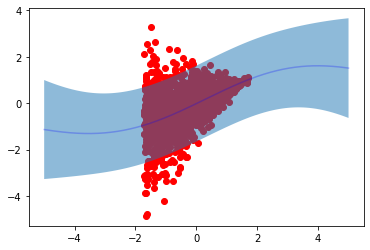

In [15]:
from gpflow.base import Parameter
from gpflow.utilities import positive

input, output = x[76], y[76]
print("Data created")

# input = StandardScaler().fit_transform(input).astype(np.float64)
# output = StandardScaler().fit_transform(output).astype(np.float64) 

sq_exp = gpflow.kernels.SquaredExponential(
        lengthscales=[0.01]
    )
sq_exp.variance.assign(1)
kernel = sq_exp
reg_gp_model = gpflow.models.GPR(data=(input, output), kernel=kernel, mean_function=None)
reg_gp_model.likelihood.variance = Parameter(
    0.1, transform=positive(lower=1e-6)
)
# Fit model
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    reg_gp_model.training_loss, reg_gp_model.trainable_variables, options=dict(maxiter=10000)
)
print("Model fit")

obs_new = np.linspace(-5, 5, 1000)[:, None]

print(f"ELBO: {- reg_gp_model.log_marginal_likelihood()}")

pred_f_mean, pred_f_var = reg_gp_model.predict_y(
    Xnew=obs_new,
)
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.25)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()

Run number: 76
Data created
Initial hyper: lengthscale - [0.05], variance - [0.00013867]
Training everything
ELBO: 1822.2403682811619


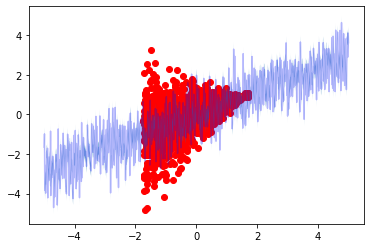

In [23]:
from gpflow.base import Parameter
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
import time


for i in wrong:
    print(f"Run number: {i}")
    if target[i] > 0:
        input = x[i]
        output = y[i]
    else:
        input = y[i]
        output = x[i]


    print("Data created")

    input = StandardScaler().fit_transform(input).astype(np.float64)
    output = StandardScaler().fit_transform(output).astype(np.float64) 

    kernel_variance = 1.0
    # Likelihood variance
    kappa = np.random.uniform(
        low=40.0, high=100, size=[1]
    )
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1.0, high=100, size=[2]
    )

    latent_dim = 1
    num_inducing = 100

    kernel_lengthscale = 1. / lamda
    kernel_lengthscale = [0.05]
    likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

    print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")

    sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale[0], kernel_lengthscale[0] * 4])

    linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    # linear_kernel_2 = gpflow.kernels.Linear(variance=kernel_variance)
    # poly_kernel = gpflow.kernels.Polynomial(degree=2, variance=kernel_variance)

    sq_exp.variance.assign(kernel_variance)

    # quadratic_kernel = gpflow.kernels.Product([linear_kernel, linear_kernel_2])

    kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])

    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.concatenate(
            [
                np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1),
                np.random.randn(num_inducing, 1),
            ],
            axis=1
        )
    )
    X_mean_init =  tf.cast(output, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (input.shape[0], latent_dim)), default_float()
    )

    m = PartObsBayesianGPLVM(
        data=output,
        in_data=input,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        inducing_variable=inducing_variable,
        jitter=1e-6
    )

    # Train everything
    tf.print("Training everything")
    gpflow.utilities.set_trainable(m.kernel, True)
    gpflow.utilities.set_trainable(m.likelihood, True)
    gpflow.utilities.set_trainable(m.X_data_mean , True)
    gpflow.utilities.set_trainable(m.X_data_var, True)
    gpflow.utilities.set_trainable(m.inducing_variable, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=10000),
    )
    tf.print("ELBO:", - m.elbo())

    loss = - m.elbo()

    obs_new = np.linspace(-5, 5, 1000)[:, None]

    Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    Xnew = tf.cast(Xnew, dtype=default_float())
    Xnew = tf.concat(
        [obs_new, Xnew], axis=1
    )
    pred_f_mean, pred_f_var = m.predict_y(
        Xnew=Xnew,
    )
    plt.scatter(input[:, 0], output[:, 0], c='r')
    plt.plot(obs_new, pred_f_mean, c='b', alpha=0.25)
    # plt.scatter(inducing_in, np.zeros(100) )
    plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    plt.show()
    plt.close()

In [24]:
from gpflow.utilities import print_summary
print_summary(m)

╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                                │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════╡
│ PartObsBayesianGPLVM.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 0.4879799685830278                   │
├─────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────┤
│ PartObsBayesianGPLVM.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 1.37065

In [ ]:
obs_new = np.linspace(-5, 5, 4000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = m.predict_y(
    Xnew=Xnew,
)

ValueError: Specified explicitly.  Tensor shape=(4000, 1) dtype=float64 dimension -1 must have size 2.  Received size 1, shape (4000, 1)

NameError: name 'pred_f_mean' is not defined

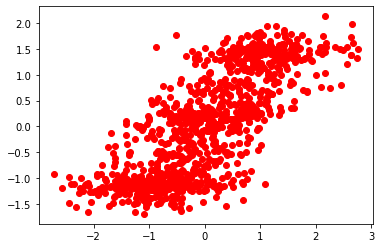

In [ ]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.25)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()

In [ ]:
-m.elbo().numpy()

array([990.04883596])

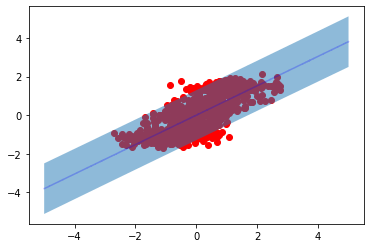

In [17]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.25)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()

In [18]:
-m.elbo().numpy()

array([990.048806])

In [39]:
-m.elbo().numpy()

2022-06-20 12:37:39.104391: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-20 12:37:39.104528: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fa606011500 = {1, 0} LB is not finite!


InvalidArgumentError: LB is not finite! : Tensor had NaN values [Op:CheckNumerics]

In [18]:
from gpflow.utilities import print_summary
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════╡
│ BayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 3.3537760044870857   │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────┤
│ BayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 2.582272150419165    │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────┤
│ BayesianGPLVM.likelihood.varianc

In [19]:
obs_new = np.linspace(-5, 5, 40)[:, None]
pred_y_mean, pred_y_var = m.predict_y(Xnew=obs_new)

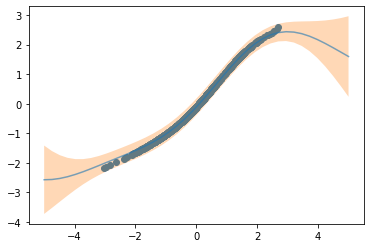

In [20]:
ind = np.argsort(m.X_data_mean[:, 0])
x_values = np.take_along_axis(m.X_data_mean.numpy()[:, 0], ind, axis=0)
# pred_y_mean_new = np.take_along_axis(pred_y_mean.numpy()[:, 0], ind, axis=0) 
# pred_y_var_new = np.take_along_axis(pred_y_var.numpy()[:, 0], ind, axis=0)

plt.scatter(m.X_data_mean, input)
plt.plot(obs_new, pred_y_mean, alpha=0.6)
plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:, 0], alpha=0.3)
plt.show()

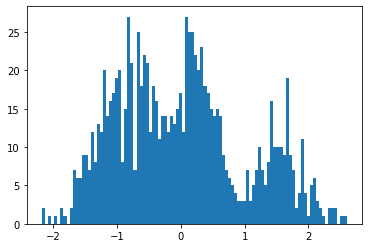

In [21]:
plt.hist(input, bins=100)
plt.show()

In [13]:
-m.elbo().numpy()

1408.8150497471183

In [23]:
-m.elbo().numpy()

1389.4006814392305

In [ ]:
407.47064394770905
391.04231501580705

In [98]:
from scipy.stats import norm
def ml_estimate(x):
    """
    Find the log likelihood.

    This doesn't make sense after I have normalised the data.
    """
    score = - np.sum( np.log(
            norm.pdf(x, loc=x.mean(), scale=x.std())

    ))
    print(norm.pdf(x, loc=x.mean(), scale=x.std()))
    return score

In [86]:
print( ml_estimate(x[2]), ml_estimate(y[2]), ml_estimate(np.random.normal(0, 1.5, 10000)))

[[0.2326027 ]
 [0.31852053]
 [0.13892459]
 ...
 [0.35506125]
 [0.39891987]
 [0.17203474]]
[[0.36215618]
 [0.38905551]
 [0.28767247]
 ...
 [0.3981433 ]
 [0.39889956]
 [0.258324  ]]
[0.17355695 0.26539336 0.1214141  ... 0.23633496 0.25741284 0.03818973]
14189.385332046726 14189.385332046728 18214.40122066285


In [8]:
tf.config.list_physical_devices('GPU')


[]

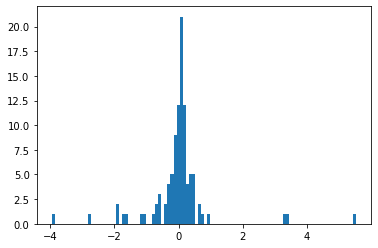

In [251]:
plt.hist(y[2], bins=100)
plt.show()

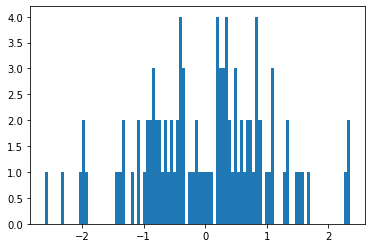

In [75]:
plt.hist(x[2], bins=100)
plt.show()

In [14]:
a = tf.Variable(1.0)
tf.debugging.check_numerics(a, message='')

b = tf.Variable(np.nan)
# try:
tf.debugging.check_numerics(b, message='Checking b')
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message

c = tf.Variable(np.inf)
try:
  tf.debugging.check_numerics(c, message='Checking c')
except Exception as e:
  assert "Checking c : Tensor had Inf values" in e.message

InvalidArgumentError: Checking b : Tensor had NaN values [Op:CheckNumerics]

In [9]:
5541508.04182404 / 0.3

18471693.4727468

In [10]:
18471693.4727468

18471693.4727468

In [4]:
import tensorflow as tf
import gpflow
import gpflux
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_probability as tfp

num_data = input.shape[0]
NUM_INDUCING = 100
X = input
Y = output

w_dim = 1
prior_means = np.zeros(w_dim)
prior_std = np.ones(w_dim)
encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
prior = tfp.distributions.MultivariateNormalDiag(prior_means, prior_std)
lv = gpflux.layers.LatentVariableLayer(prior, encoder)

/tmp/ipykernel_2943335/3648081335.py:18: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
2022-06-16 18:17:39.735563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 18:17:39.746724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 18:17:39.747388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had nega

In [5]:
kernel = gpflow.kernels.SquaredExponential(lengthscales=[.05, .2], variance=1.)
inducing_variable = gpflow.inducing_variables.InducingPoints(
np.concatenate(
    [
        np.linspace(X.min(), X.max(), NUM_INDUCING).reshape(-1, 1),
        np.random.randn(NUM_INDUCING, 1),
    ],
    axis=1
)
)
gp_layer = gpflux.layers.GPLayer(
kernel,
inducing_variable,
num_data=num_data,
num_latent_gps=1,
mean_function=gpflow.mean_functions.Zero(),
)

/homes/ad6013/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


In [6]:
kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer2 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer2.q_sqrt.assign(gp_layer.q_sqrt * 1e-5);

In [7]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
gpflow.set_trainable(likelihood_layer, False)
dgp = gpflux.models.DeepGP([lv, gp_layer, gp_layer2], likelihood_layer)
gpflow.utilities.print_summary(dgp, fmt="notebook")

/tmp/ipykernel_2943335/481218405.py:1: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
2022-06-16 18:17:40.893038: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [8]:
model = dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.005))


In [9]:
history = model.fit({"inputs": X, "targets": Y}, epochs=int(20e3), verbose=0, batch_size=num_data, shuffle=False)

In [ ]:
gpflow.utilities.print_summary(dgp, fmt="notebook")


In [22]:
import gpflow as gpf


likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)
# The number of kernels contained in gpf.kernels.SeparateIndependent must be the same as likelihood.latent_dim


M = 100  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(input.min(), input.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)


Likelihood's expected latent_dim: 2


In [23]:
data = (input, output)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [25]:
def plot_distribution(X, Y, loc, scale):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()
    for k in (1, 2):
        lb = (loc - k * scale).squeeze()
        ub = (loc + k * scale).squeeze()
        plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
    plt.plot(x, lb, color="silver")
    plt.plot(x, ub, color="silver")
    plt.plot(X, loc, color="black")
    plt.scatter(X, Y, color="gray", alpha=0.8)
    plt.show()
    plt.close()


Epoch 20 - Loss:  910.2846


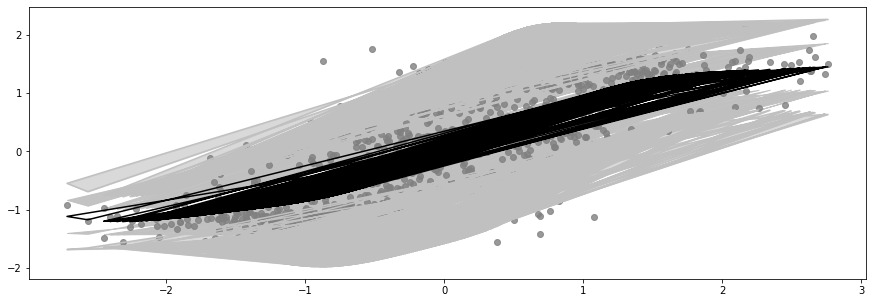

Epoch 40 - Loss:  910.2214


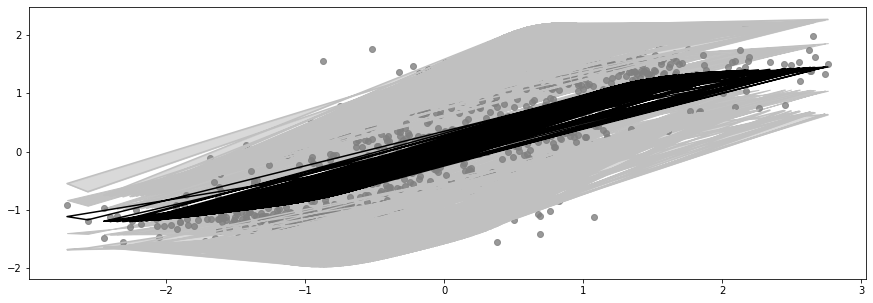

Epoch 60 - Loss:  910.2381


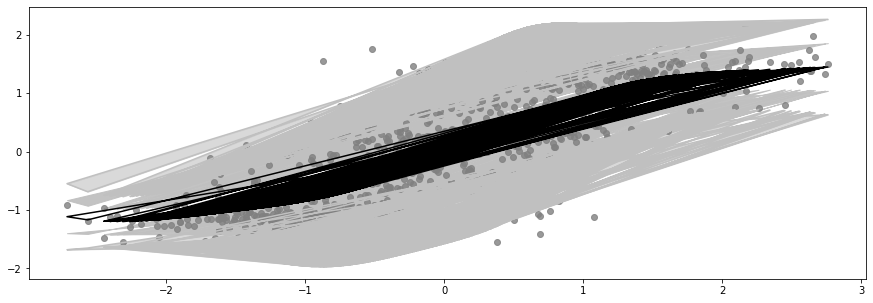

Epoch 80 - Loss:  910.1163


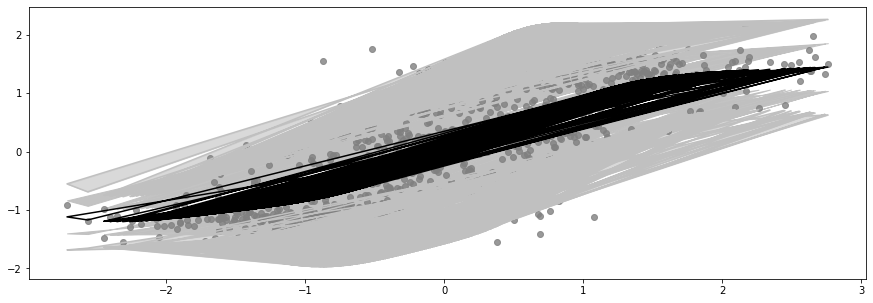

Epoch 100 - Loss:  910.0732


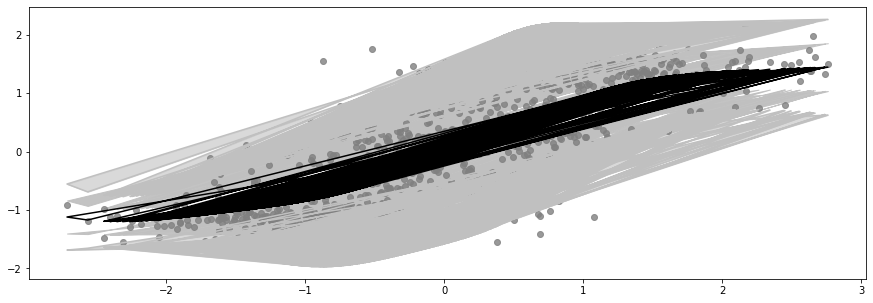

Epoch 120 - Loss:  910.0110


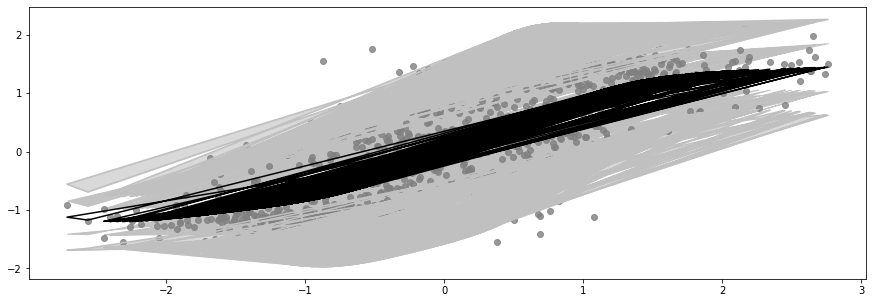

Epoch 140 - Loss:  909.9603


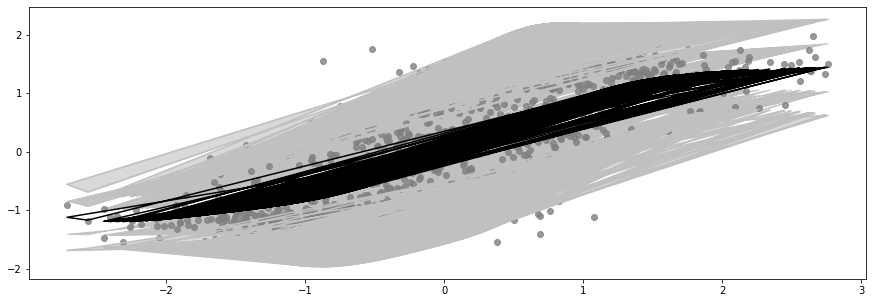

Epoch 160 - Loss:  909.9240


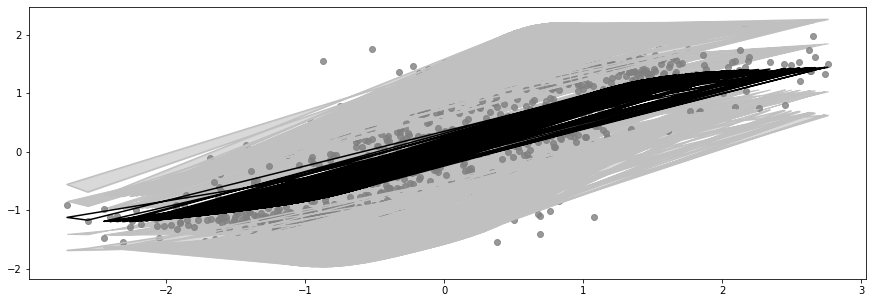

Epoch 180 - Loss:  909.8476


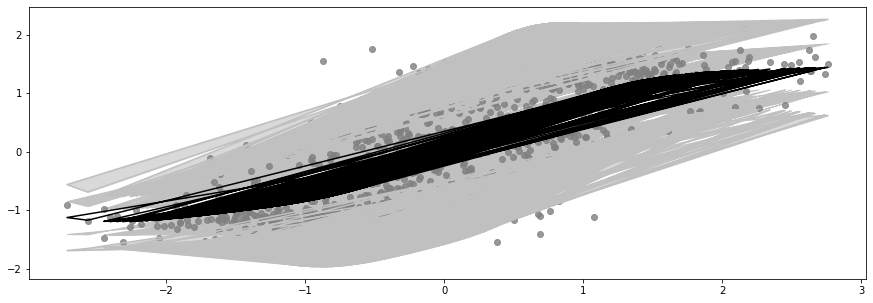

Epoch 200 - Loss:  909.8189


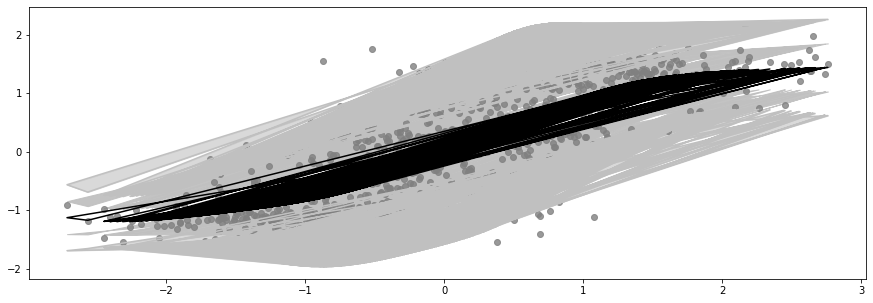

Epoch 220 - Loss:  909.7489


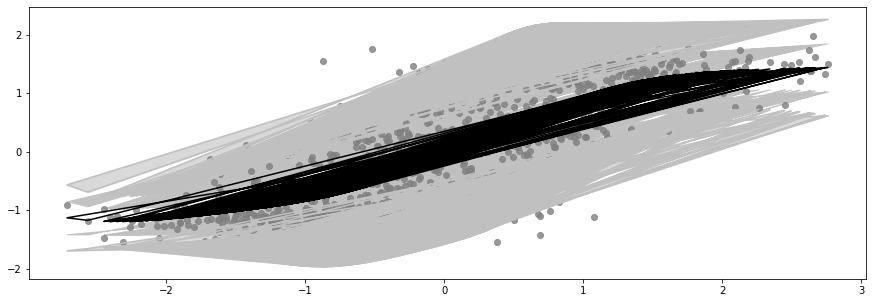

Epoch 240 - Loss:  909.6831


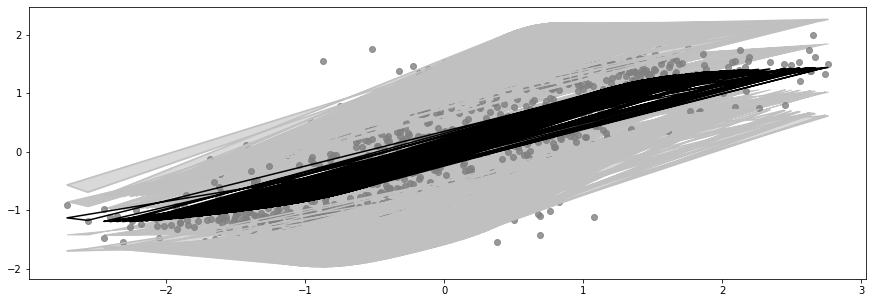

Epoch 260 - Loss:  909.6238


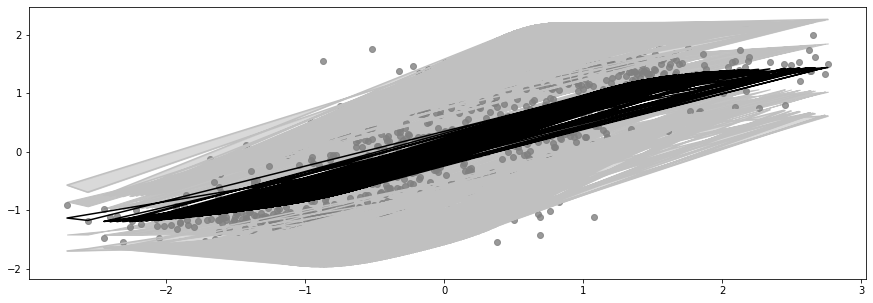

Epoch 280 - Loss:  909.5537


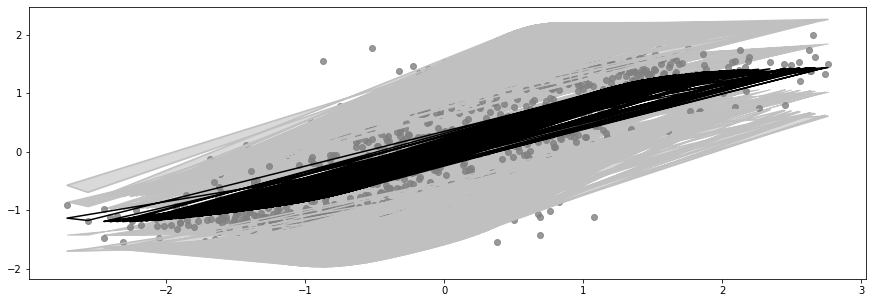

Epoch 300 - Loss:  909.5035


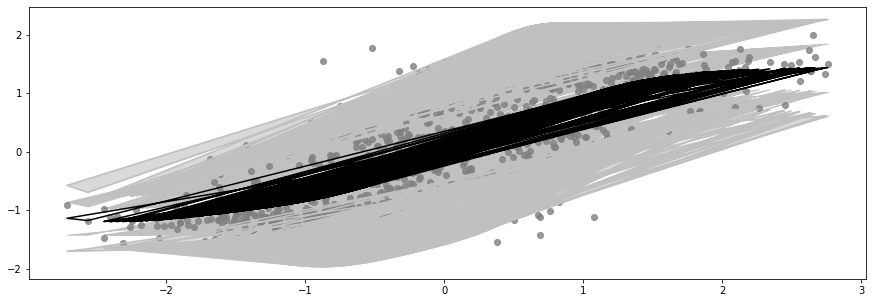

Epoch 320 - Loss:  909.4526


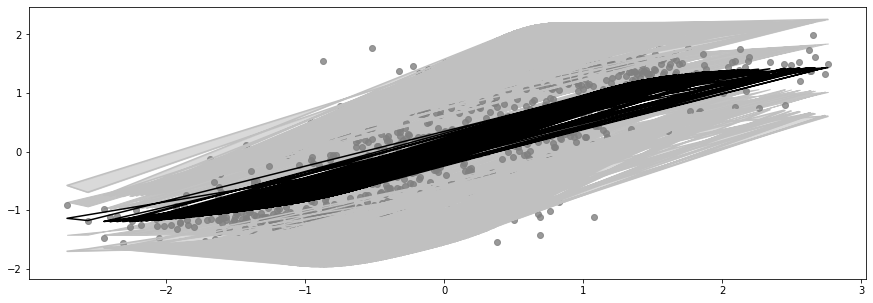

Epoch 340 - Loss:  909.3769


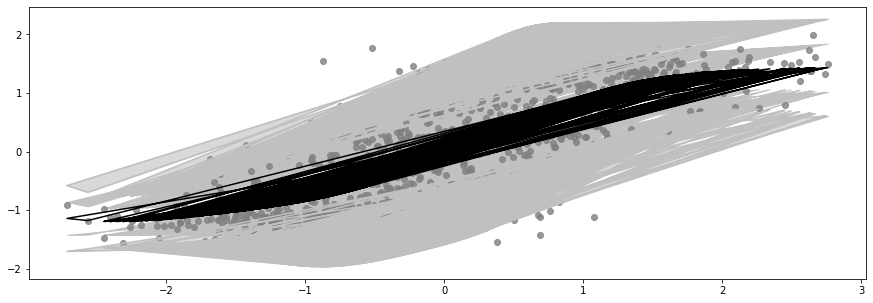

Epoch 360 - Loss:  909.2957


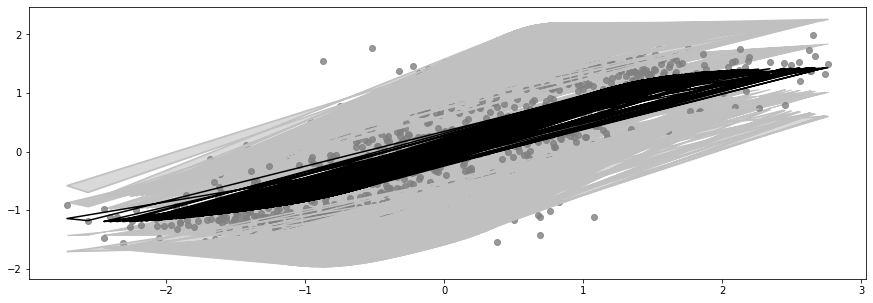

Epoch 380 - Loss:  909.2467


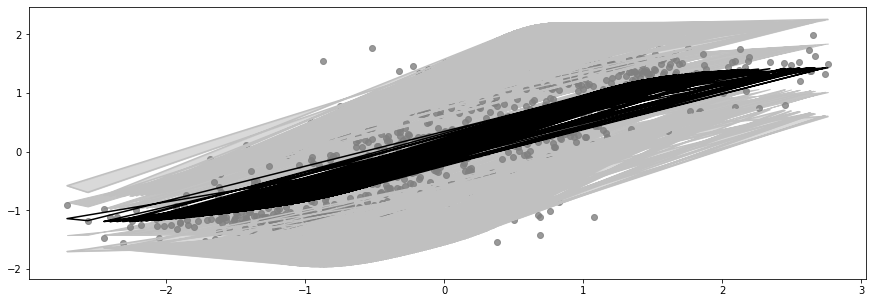

Epoch 400 - Loss:  909.1756


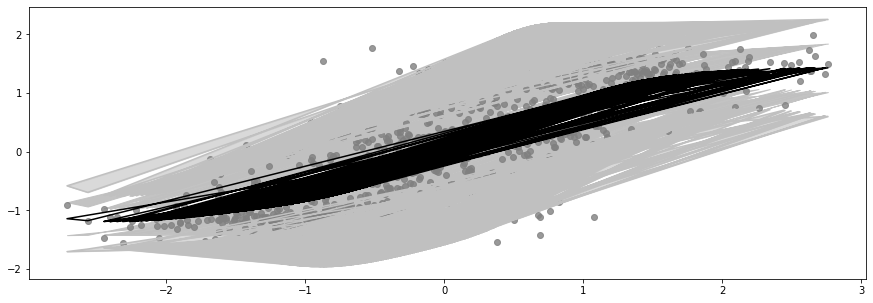

Epoch 420 - Loss:  909.1182


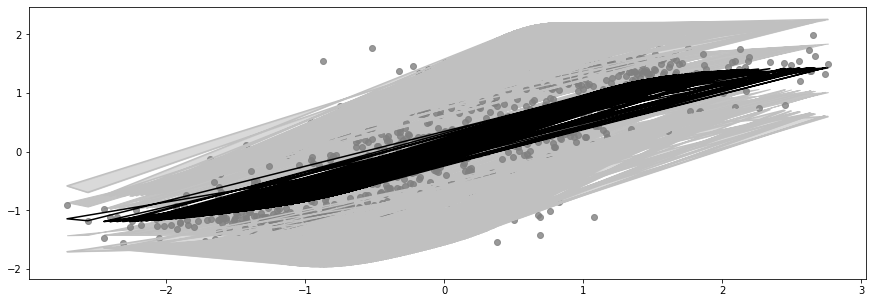

Epoch 440 - Loss:  909.0568


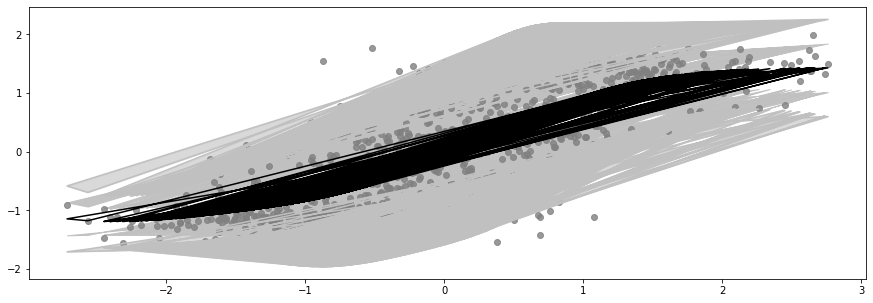

Epoch 460 - Loss:  908.9971


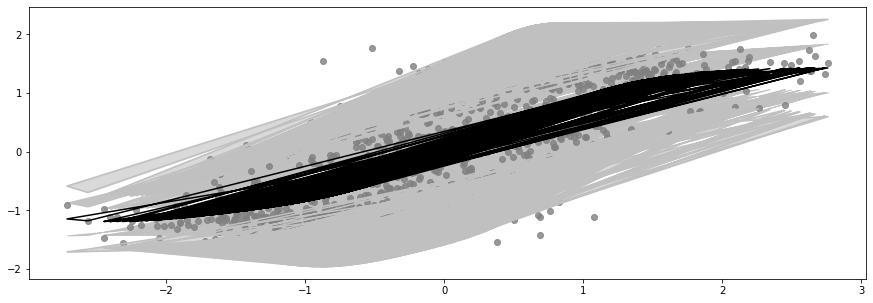

Epoch 480 - Loss:  908.9656


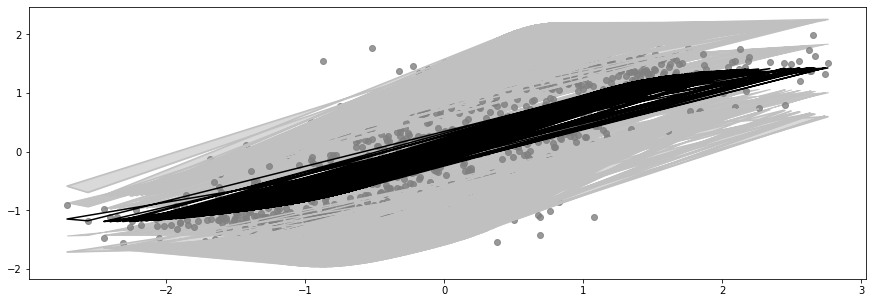

Epoch 500 - Loss:  908.8883


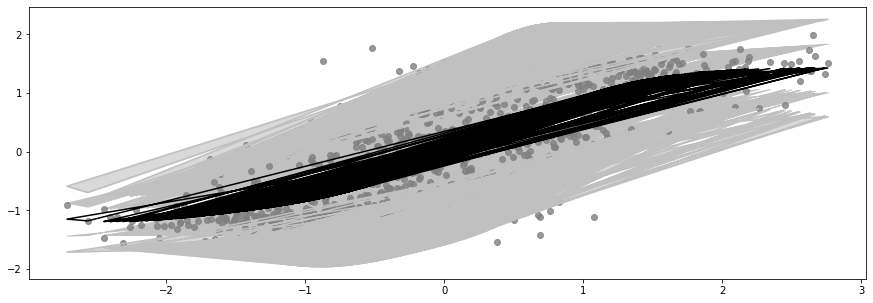

Epoch 520 - Loss:  908.8436


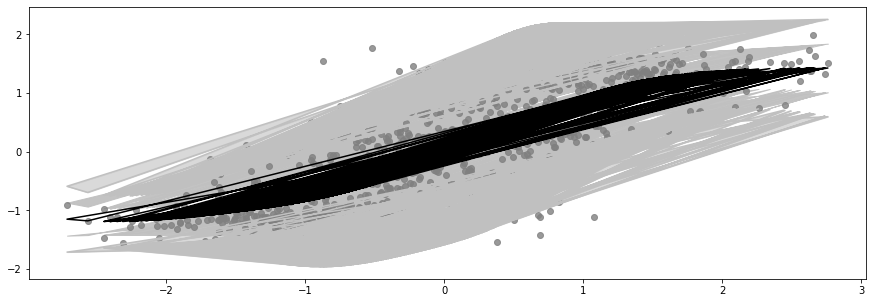

Epoch 540 - Loss:  908.8062


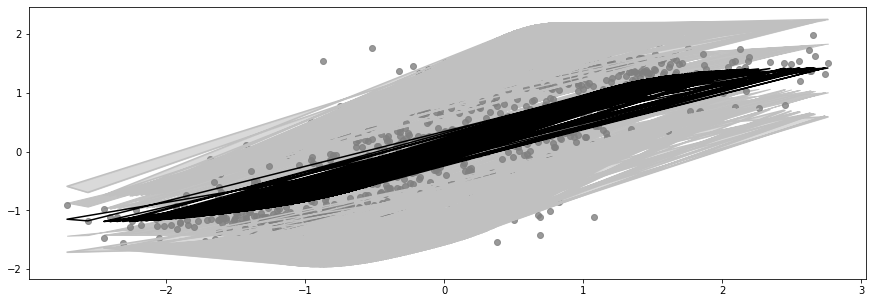

Epoch 560 - Loss:  908.7334


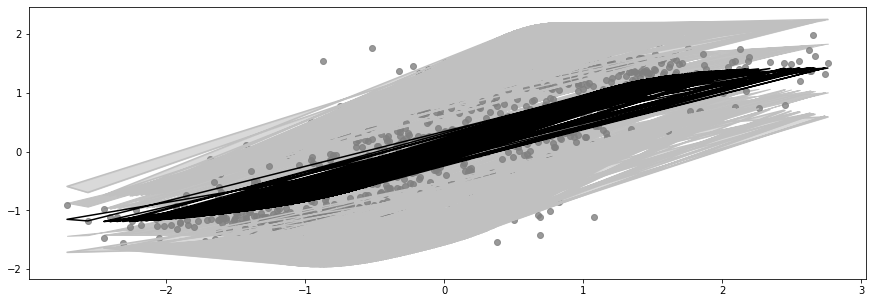

Epoch 580 - Loss:  908.7094


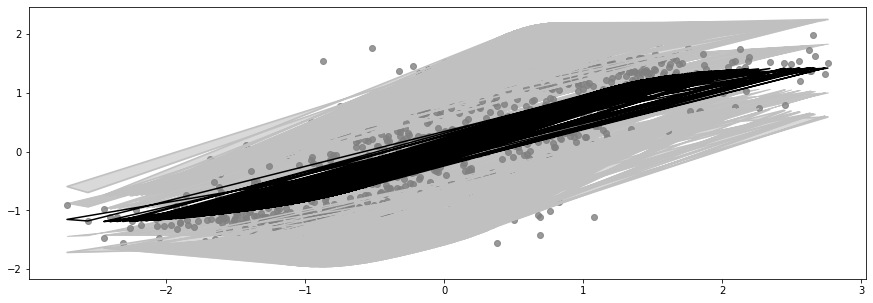

Epoch 600 - Loss:  908.6344


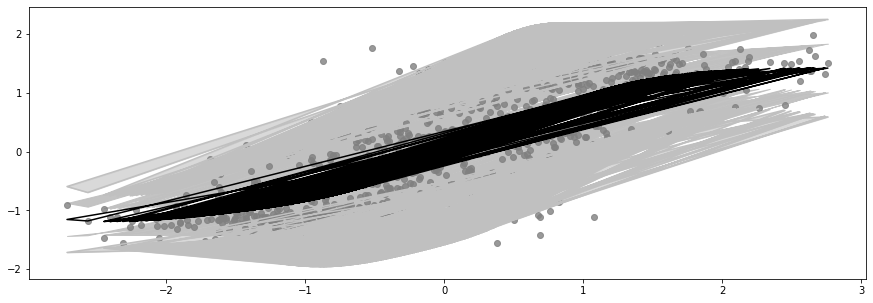

Epoch 620 - Loss:  908.6180


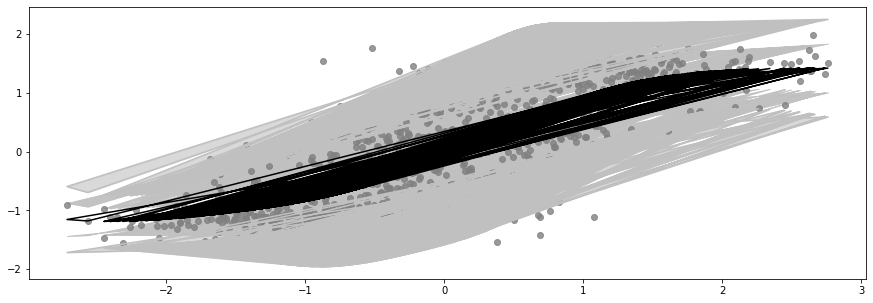

Epoch 640 - Loss:  908.5575


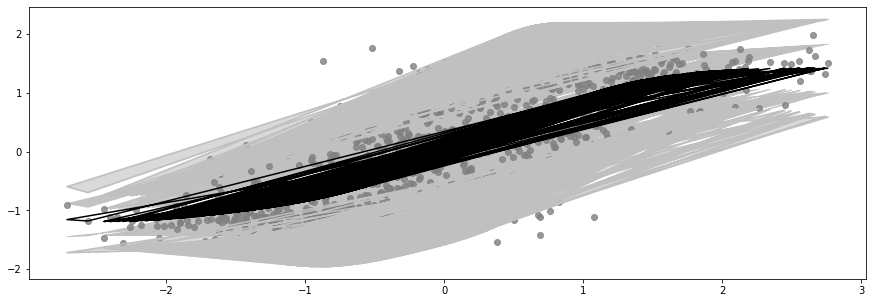

Epoch 660 - Loss:  908.5106


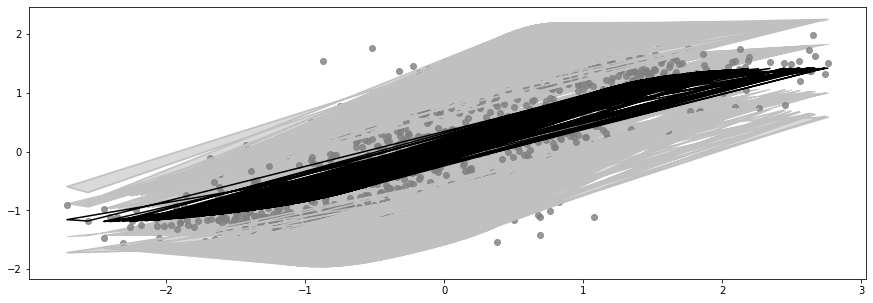

Epoch 680 - Loss:  908.4684


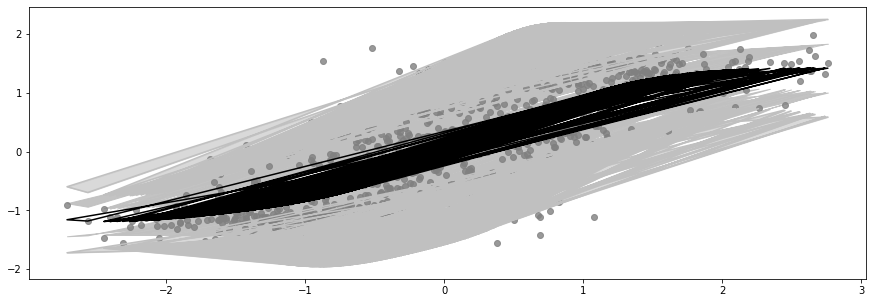

Epoch 700 - Loss:  908.4278


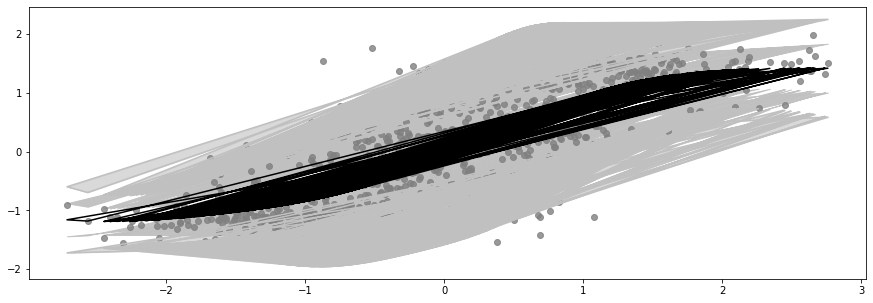

Epoch 720 - Loss:  908.3975


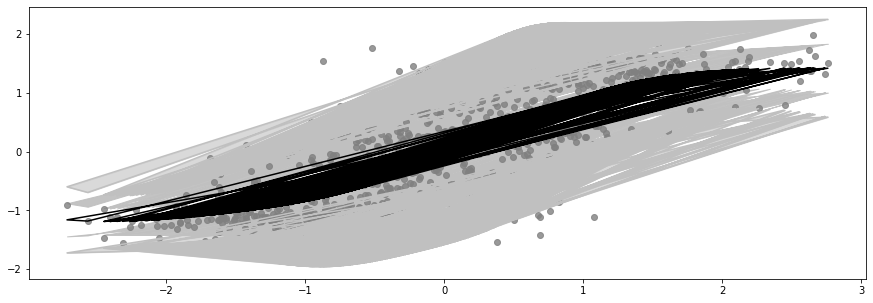

Epoch 740 - Loss:  908.3555


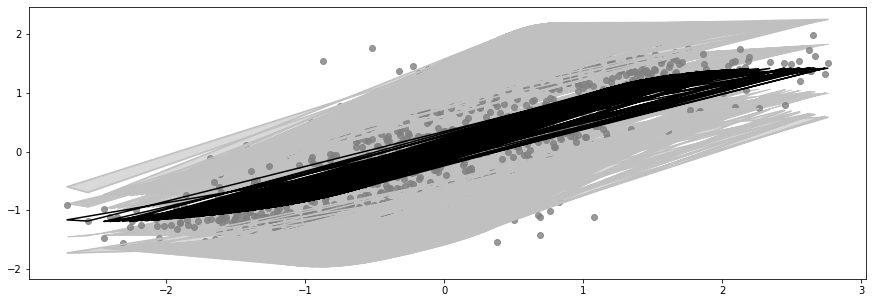

Epoch 760 - Loss:  908.3143


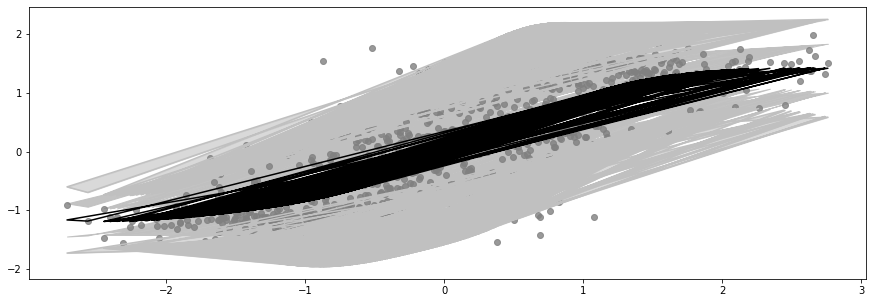

Epoch 780 - Loss:  908.2886


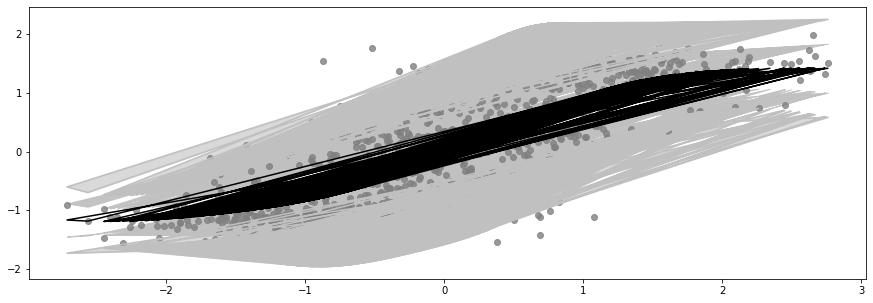

Epoch 800 - Loss:  908.2721


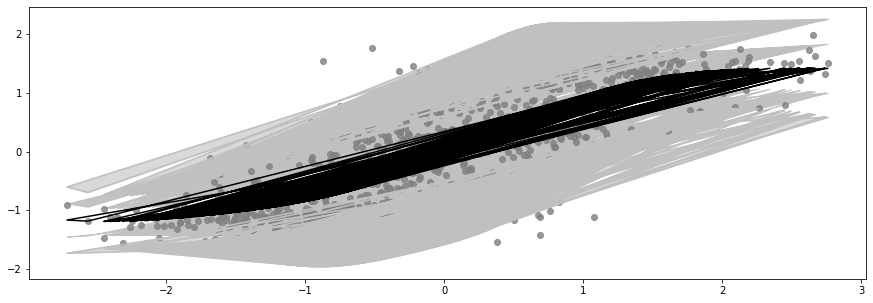

Epoch 820 - Loss:  908.2259


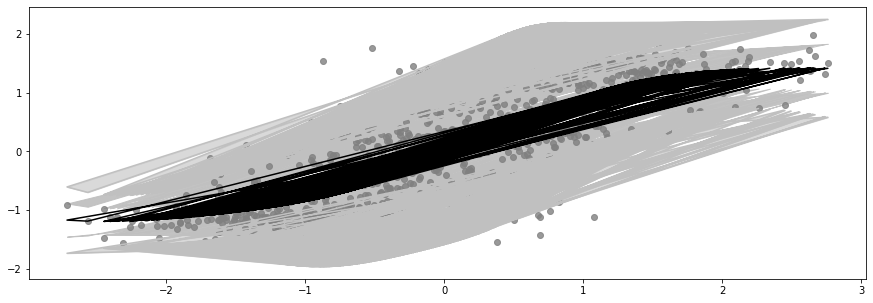

Epoch 840 - Loss:  908.1910


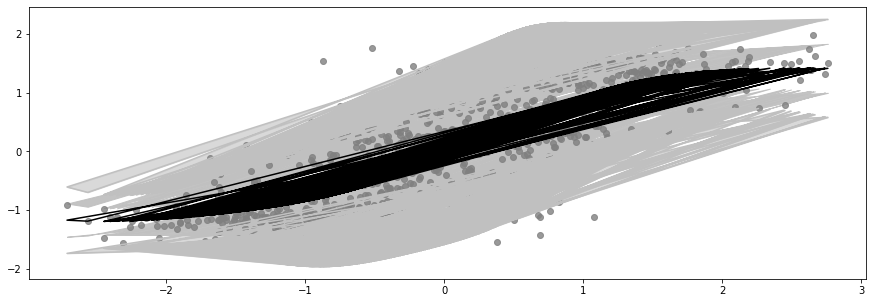

Epoch 860 - Loss:  908.1650


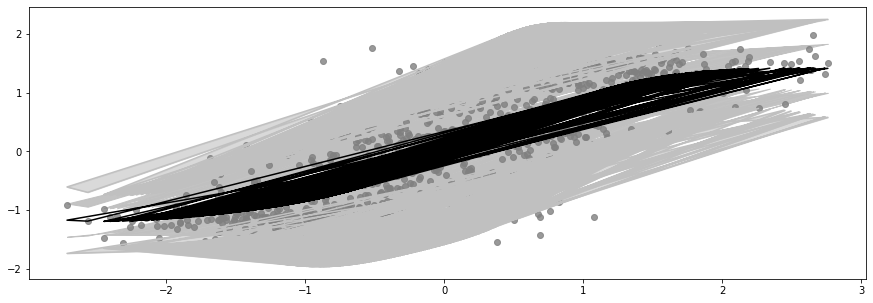

Epoch 880 - Loss:  908.1289


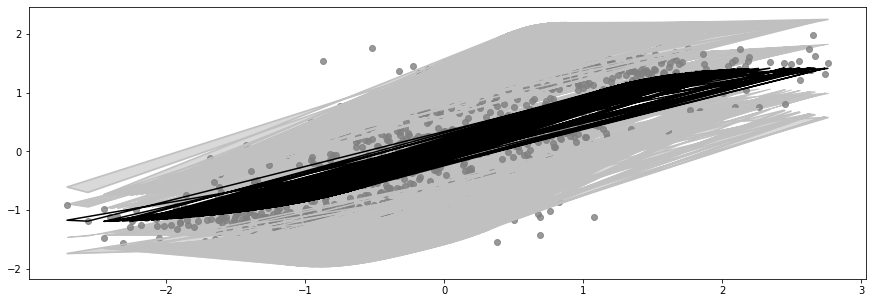

Epoch 900 - Loss:  908.1097


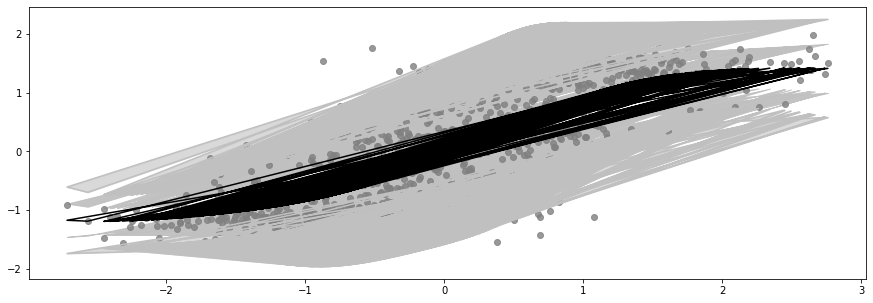

Epoch 920 - Loss:  908.0793


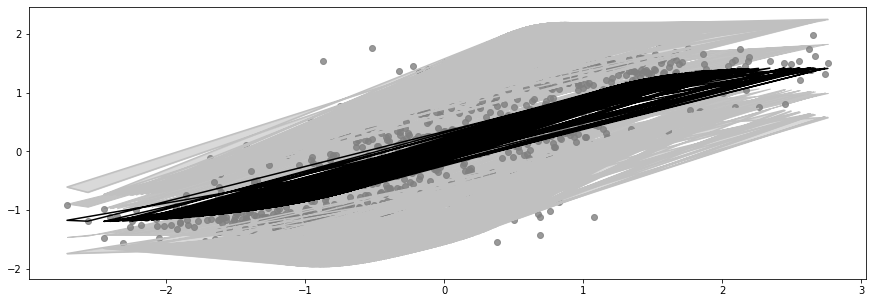

Epoch 940 - Loss:  908.0565


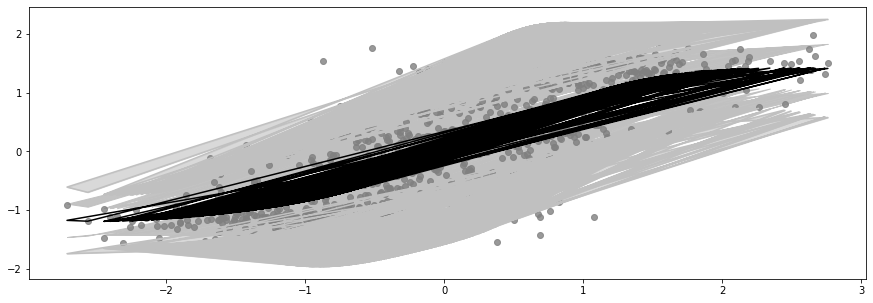

Epoch 960 - Loss:  908.0423


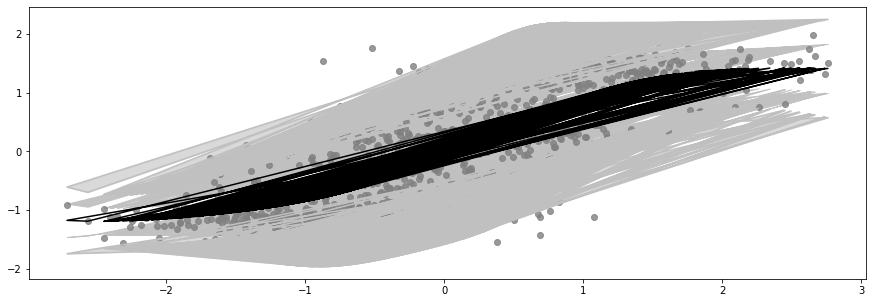

Epoch 980 - Loss:  908.0228


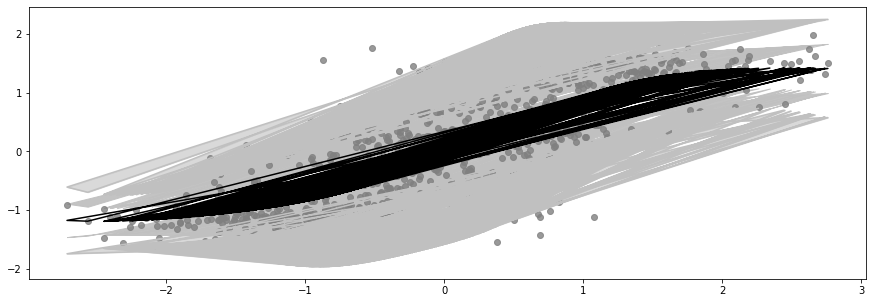

Epoch 1000 - Loss:  907.9866


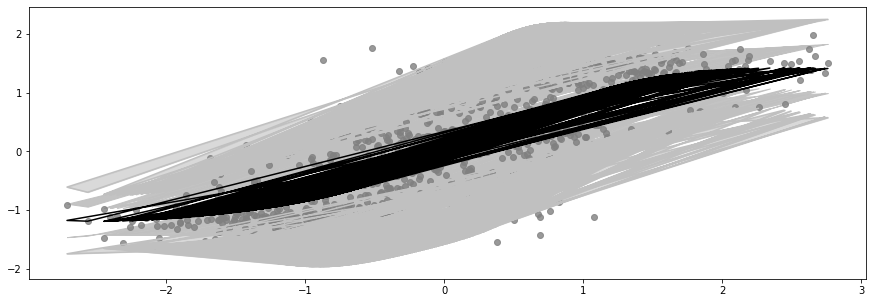

<gpflow.models.svgp.SVGP object at 0x7f98343d49d0>
╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 0.9076936851089614                                   │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernels[0].lengthscales                │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 1.4253451127055135                                   │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].variance                    │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 0.8005297738023835                                   │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].lengthscales                │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 0.992391871357655                                    │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[0].Z │ Parameter │ Identity       │         │ True        │ (100, 1)      │ float64 │ [[-2.88875688e+00...                                 │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[1].Z │ Parameter │ Identity       │         │ True        │ (100, 1)      │ float64 │ [[-2.79160523...                                     │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.q_mu                                          │ Parameter │ Identity       │         │ False       │ (100, 2)      │ float64 │ [[-1.20130356e+00, -1.51988697e+00...                │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.q_sqrt                                        │ Parameter │ FillTriangular │         │ False       │ (2, 100, 100) │ float64 │ [[[1.59549424e-01, 0.00000000e+00, 0.00000000e+00... │
╘════════════════════════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═══════════════╧═════════╧══════════════════════════════════════════════════════╛

In [28]:
epochs = 1000
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(input)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(input, output, Ymean, Ystd)

model

In [3]:
file = "/vol/bitbucket/ad6013/Research/gp-causal/CE-Cha_pairs.csv"

In [4]:
import numpy as np
import csv

with open(file, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader))[:, 1:]
    
print(headers)

FileNotFoundError: [Errno 2] No such file or directory: '/vol/bitbucket/ad6013/Research/gp-causal/CE-Cha_pairs.csv'

In [ ]:
processed_data = np.zeros((data.shape[0], 1500, 2))
for i in range(data.shape[0]):
    x = np.array(data[i, 0].split()).astype(float)
    y = np.array(data[i, 1].split()).astype(float)
    processed_data[i, :, 0],  processed_data[i, :, 1] = x, y

In [ ]:
processed_data

array([[[ -5013.,  -3471.],
        [ -9057.,   2643.],
        [ -2732.,  -6145.],
        ...,
        [  -519., -12202.],
        [ -5742.,   8363.],
        [   454.,  -4813.]],

       [[ -5254.,  -2690.],
        [-17105., -15442.],
        [  1546.,   2758.],
        ...,
        [ -2985.,   -751.],
        [  2299.,   3206.],
        [ -3552.,   3445.]],

       [[  3597.,   3220.],
        [  3838.,  -4447.],
        [ -1009.,   2111.],
        ...,
        [  3251.,  -4119.],
        [  3960.,  -4867.],
        [  3293.,  -3014.]],

       ...,

       [[  3074.,  -3497.],
        [ -2299.,  -9480.],
        [  9224.,   9552.],
        ...,
        [-10498.,  -9230.],
        [ -1545.,    814.],
        [ -3568.,  -3265.]],

       [[ -9068.,  -8923.],
        [ -6794.,  -7000.],
        [ -1788.,   5859.],
        ...,
        [-10288.,  -9660.],
        [ -2112.,   -963.],
        [  9816.,  10117.]],

       [[  8078.,  11778.],
        [ 18956.,  11665.],
        [ -4987.

In [49]:
file_2 = "/vol/bitbucket/ad6013/Research/gp-causal/data/cha_pairs/files/CE-Cha_targets.csv"

In [50]:
import numpy as np
import csv

with open(file_2, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    target_data = np.array(list(reader))[:, 1:].astype(float)
    
print(headers)

['SampleID', 'Target']


In [53]:
target_data.shape

(300, 1)

In [54]:
import csv
import numpy as np


path = "/vol/bitbucket/ad6013/Research/gp-causal/data/dream_pairs/files"
name = "D4S1"

In [55]:
file_pairs = f"{path}/{name}.csv"
with open(file_pairs, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader))[:, 1:]

In [62]:
data_dict = dict()

processed_data = np.zeros((data.shape[0], len(data[0, 0].split()), 2))
target_data = np.zeros((data.shape[0], 1))
idx = 0
for i in range(data.shape[0]):
    x = np.array(data[i, 0].split()).astype(float)
    y = np.array(data[i, 1].split()).astype(float)
    target = data[i, 2].astype(float)
    if target != 0:
        print(target)
        processed_data[idx, :, 0],  processed_data[idx, :, 1] = x, y
        target_data[idx] = target
        idx += 1
    else:
        pass

data_dict['cause'] = processed_data[:idx, :, 0:1]
data_dict['effect'] = processed_data[:idx, :, 1:2]
data_dict['weight'] = np.ones(data.shape[0])[:idx]

data_dict['target'] = target_data[:idx]

1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0


In [66]:
data_dict["effect"].shape

(24, 105, 1)

In [61]:
idx

24

In [19]:
import numpy as np

X = np.random.uniform(-1, 1, 1000)
noise = np.random.binomial(1, 0.5, 1000) 
noise[noise == 0] = -1
Y = X * noise

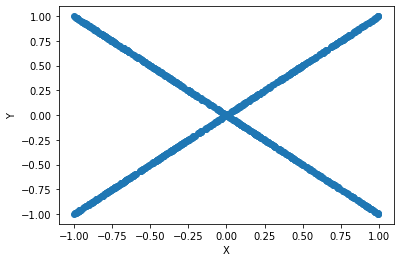

In [20]:
import matplotlib.pyplot as plt


plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [5]:
X

array([], shape=(0, 1, 1000), dtype=float64)

In [10]:
np.random.binomial(1, 0.5, 1000)

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,